In [23]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Convolution1D, MaxPooling1D, Flatten, Dense, Dropout, TimeDistributed, MaxPooling2D
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import categorical_crossentropy
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from datetime import datetime
import seaborn as sns
from pylab import rcParams
from keras.layers import Dropout
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
rcParams['figure.figsize'] = 14, 10
from tensorflow import keras
eval_list = []

In [24]:
needfile = '/emogen/all'
def call_filelist(needfile):
    path = os.getcwd()
    files = os.listdir(path + needfile)
    if '.ipynb_checkpoints' in files:
        files.remove('.ipynb_checkpoints')
    return files

# 데이터 프레임 불러오기
def call_file(files, num, needfile):
    path = os.getcwd()
    df = pd.read_csv(path + needfile+ '/' + files[num], index_col = 0)
    df.set_index('Current Time',inplace = True)
    return df



In [25]:
files = call_filelist(needfile)
df = call_file(files, 0, needfile)


X = df.iloc[:, :-7].values
y = df.iloc[:, -7:].values


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)


history_loss = []
history_accuracy = []
history_val_loss = []
history_val_accuracy = []
print(X_train.shape)


(4628, 8)


In [26]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
print(X_train.shape)

(4628, 8, 1)


In [36]:
"""
model = Sequential()
model.add(Convolution1D(128, 3, activation='relu', input_shape = (X_train.shape[0], X_train.shape[2])))
model.add(MaxPooling1D(pool_size=2))
model.add(Dense(64, activation='softmax'))
model.add(LSTM(64, input_shape = (X_train.shape[0], X_train.shape[2]), recurrent_dropout=0.5))
model.add(Dropout(0.5))
model.add(Dense(y_train.shape[1], activation='softmax'))
"""
from keras.optimizers import RMSprop

opt = RMSprop(learning_rate=0.0001)

model = Sequential()
model.add(Convolution1D(filters=128, kernel_size=3, activation='relu', input_shape=(X_train.shape[1],1)))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(64,return_sequences=True, activation='softmax'))
model.add(Dropout(0.2))
model.add(LSTM(32,return_sequences=True, activation='softmax'))
model.add(Dropout(0.2))
model.add(LSTM(y_train.shape[1], activation='softmax'))

In [37]:
model.compile(loss=categorical_crossentropy , optimizer=opt, metrics=['accuracy'])

In [40]:
for num in range(len(files)):
    df = call_file(files, num, needfile)
    print(files[num])
    # 입력 데이터와 라벨 데이터를 분리
    X = df.iloc[:, :-7].values
    y = df.iloc[:, -7:].values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2)
    # 입력 데이터를 3D 텐서로 변환
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)


    print(X_train.shape)
    earlystop = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights = True)
    # 모델 학습 및 체크포인트 저장
    fit_history = model.fit(X_train, y_train, epochs=100, batch_size=3, validation_data=(X_val, y_val), callbacks=[earlystop])
    history_loss.extend(fit_history.history['loss'])
    history_accuracy.extend(fit_history.history['accuracy'])
    history_val_loss.extend(fit_history.history['val_loss'])
    history_val_accuracy.extend(fit_history.history['val_accuracy'])

    # 모델 평가
    loss, accuracy = model.evaluate(X_test, y_test)
    eval_list.append(accuracy)
    print('Test accuracy:', accuracy)
    print(num)
    #모델 저장
    model.save("my_model.h5")
    reconstructed_model = keras.models.load_model("my_model.h5")
    np.testing.assert_allclose(model.predict(X_test), 
                               reconstructed_model.predict(X_test)
                              )
    model = reconstructed_model
    model.compile(loss=categorical_crossentropy , optimizer='rmsprop', metrics=['accuracy'])


User002M_new_emo_gender.csv
(4165, 8, 1)
Epoch 1/100
1389/1389 [==============================] - 8s 6ms/step - loss: 0.4136 - accuracy: 0.8843 - val_loss: 0.4311 - val_accuracy: 0.8743
Epoch 2/100
1389/1389 [==============================] - 8s 6ms/step - loss: 0.4132 - accuracy: 0.8843 - val_loss: 0.4316 - val_accuracy: 0.8743
Epoch 3/100
1389/1389 [==============================] - 8s 6ms/step - loss: 0.4136 - accuracy: 0.8843 - val_loss: 0.4319 - val_accuracy: 0.8743
Epoch 4/100
1389/1389 [==============================] - 8s 6ms/step - loss: 0.4146 - accuracy: 0.8843 - val_loss: 0.4321 - val_accuracy: 0.8743
Epoch 5/100
1389/1389 [==============================] - 8s 6ms/step - loss: 0.4142 - accuracy: 0.8843 - val_loss: 0.4325 - val_accuracy: 0.8743
Epoch 6/100
1389/1389 [==============================] - 8s 5ms/step - loss: 0.4151 - accuracy: 0.8843 - val_loss: 0.4327 - val_accuracy: 0.8743
Epoch 6: early stopping
19/19 [==============================] - 0s 3ms/step - loss: 0.45

1557/1557 [==============================] - 8s 5ms/step - loss: 0.6952 - accuracy: 0.8289 - val_loss: 0.7816 - val_accuracy: 0.8159
Epoch 21: early stopping
21/21 [==============================] - 0s 3ms/step - loss: 0.6756 - accuracy: 0.8305
Test accuracy: 0.8305084705352783
3
21/21 [==============================] - 0s 3ms/step
User006M_new_emo_gender.csv
(4666, 8, 1)
Epoch 1/100
1556/1556 [==============================] - 12s 6ms/step - loss: 0.7599 - accuracy: 0.7968 - val_loss: 0.7740 - val_accuracy: 0.7935
Epoch 2/100
1556/1556 [==============================] - 10s 6ms/step - loss: 0.7590 - accuracy: 0.7968 - val_loss: 0.7758 - val_accuracy: 0.7935
Epoch 3/100
1556/1556 [==============================] - 9s 6ms/step - loss: 0.7586 - accuracy: 0.7968 - val_loss: 0.7788 - val_accuracy: 0.7935
Epoch 4/100
1556/1556 [==============================] - 9s 6ms/step - loss: 0.7587 - accuracy: 0.7968 - val_loss: 0.7791 - val_accuracy: 0.7935
Epoch 5/100
1556/1556 [====================

1425/1425 [==============================] - 8s 6ms/step - loss: 0.7667 - accuracy: 0.8699 - val_loss: 0.6546 - val_accuracy: 0.8775
Epoch 3/100
1425/1425 [==============================] - 8s 6ms/step - loss: 0.7187 - accuracy: 0.8699 - val_loss: 0.6202 - val_accuracy: 0.8775
Epoch 4/100
1425/1425 [==============================] - 8s 6ms/step - loss: 0.6852 - accuracy: 0.8699 - val_loss: 0.5903 - val_accuracy: 0.8775
Epoch 5/100
1425/1425 [==============================] - 8s 6ms/step - loss: 0.6493 - accuracy: 0.8699 - val_loss: 0.5671 - val_accuracy: 0.8775
Epoch 6/100
1425/1425 [==============================] - 8s 6ms/step - loss: 0.6221 - accuracy: 0.8699 - val_loss: 0.5509 - val_accuracy: 0.8775
Epoch 7/100
1425/1425 [==============================] - 8s 6ms/step - loss: 0.6051 - accuracy: 0.8699 - val_loss: 0.5451 - val_accuracy: 0.8775
Epoch 8/100
1425/1425 [==============================] - 8s 6ms/step - loss: 0.5992 - accuracy: 0.8699 - val_loss: 0.5455 - val_accuracy: 0.87

1695/1695 [==============================] - 10s 6ms/step - loss: 0.9895 - accuracy: 0.7124 - val_loss: 1.0176 - val_accuracy: 0.6821
Epoch 8/100
1695/1695 [==============================] - 10s 6ms/step - loss: 0.9906 - accuracy: 0.7124 - val_loss: 1.0185 - val_accuracy: 0.6821
Epoch 9/100
1695/1695 [==============================] - 10s 6ms/step - loss: 0.9890 - accuracy: 0.7124 - val_loss: 1.0139 - val_accuracy: 0.6821
Epoch 10/100
1695/1695 [==============================] - 10s 6ms/step - loss: 0.9863 - accuracy: 0.7124 - val_loss: 1.0164 - val_accuracy: 0.6821
Epoch 11/100
1695/1695 [==============================] - 10s 6ms/step - loss: 0.9894 - accuracy: 0.7124 - val_loss: 1.0150 - val_accuracy: 0.6821
Epoch 12/100
1695/1695 [==============================] - 10s 6ms/step - loss: 0.9854 - accuracy: 0.7124 - val_loss: 1.0125 - val_accuracy: 0.6821
Epoch 13/100
1695/1695 [==============================] - 10s 6ms/step - loss: 0.9799 - accuracy: 0.7124 - val_loss: 1.0148 - val_acc

1667/1667 [==============================] - 13s 6ms/step - loss: 0.9116 - accuracy: 0.7906 - val_loss: 0.8651 - val_accuracy: 0.7752
Epoch 2/100
1667/1667 [==============================] - 10s 6ms/step - loss: 0.8273 - accuracy: 0.7906 - val_loss: 0.8149 - val_accuracy: 0.7752
Epoch 3/100
1667/1667 [==============================] - 10s 6ms/step - loss: 0.7795 - accuracy: 0.7906 - val_loss: 0.7728 - val_accuracy: 0.7752
Epoch 4/100
1667/1667 [==============================] - 10s 6ms/step - loss: 0.7469 - accuracy: 0.7906 - val_loss: 0.7437 - val_accuracy: 0.7752
Epoch 5/100
1667/1667 [==============================] - 10s 6ms/step - loss: 0.7307 - accuracy: 0.7906 - val_loss: 0.7319 - val_accuracy: 0.7752
Epoch 6/100
1667/1667 [==============================] - 10s 6ms/step - loss: 0.7198 - accuracy: 0.7906 - val_loss: 0.7263 - val_accuracy: 0.7752
Epoch 7/100
1667/1667 [==============================] - 10s 6ms/step - loss: 0.7195 - accuracy: 0.7906 - val_loss: 0.7268 - val_accurac

1991/1991 [==============================] - 12s 6ms/step - loss: 0.7449 - accuracy: 0.7962 - val_loss: 0.7493 - val_accuracy: 0.7924
Epoch 6/100
1991/1991 [==============================] - 12s 6ms/step - loss: 0.7483 - accuracy: 0.7962 - val_loss: 0.7513 - val_accuracy: 0.7924
Epoch 6: early stopping
26/26 [==============================] - 0s 3ms/step - loss: 0.7132 - accuracy: 0.8000
Test accuracy: 0.800000011920929
18
26/26 [==============================] - 0s 3ms/step
User035M_new_emo_gender.csv
(5437, 8, 1)
Epoch 1/100
1813/1813 [==============================] - 14s 6ms/step - loss: 0.3067 - accuracy: 0.9331 - val_loss: 0.3462 - val_accuracy: 0.9184
Epoch 2/100
1813/1813 [==============================] - 11s 6ms/step - loss: 0.2995 - accuracy: 0.9331 - val_loss: 0.3483 - val_accuracy: 0.9184
Epoch 3/100
1813/1813 [==============================] - 11s 6ms/step - loss: 0.2996 - accuracy: 0.9331 - val_loss: 0.3491 - val_accuracy: 0.9184
Epoch 4/100
1813/1813 [==================

24/24 [==============================] - 0s 3ms/step - loss: 0.7235 - accuracy: 0.7615
Test accuracy: 0.7615176439285278
21
24/24 [==============================] - 0s 3ms/step
User038F_new_emo_gender.csv
(5760, 8, 1)
Epoch 1/100
1920/1920 [==============================] - 13s 6ms/step - loss: 0.9754 - accuracy: 0.6625 - val_loss: 0.9110 - val_accuracy: 0.6750
Epoch 2/100
1920/1920 [==============================] - 10s 5ms/step - loss: 0.9352 - accuracy: 0.6625 - val_loss: 0.8809 - val_accuracy: 0.6750
Epoch 3/100
1920/1920 [==============================] - 10s 5ms/step - loss: 0.9186 - accuracy: 0.6625 - val_loss: 0.8652 - val_accuracy: 0.6750
Epoch 4/100
1920/1920 [==============================] - 10s 5ms/step - loss: 0.9127 - accuracy: 0.6625 - val_loss: 0.8600 - val_accuracy: 0.6750
Epoch 5/100
1920/1920 [==============================] - 10s 5ms/step - loss: 0.9009 - accuracy: 0.6625 - val_loss: 0.8560 - val_accuracy: 0.6750
Epoch 6/100
1920/1920 [=============================

2280/2280 [==============================] - 14s 6ms/step - loss: 1.0531 - accuracy: 0.6736 - val_loss: 1.0673 - val_accuracy: 0.6556
Epoch 13/100
2280/2280 [==============================] - 14s 6ms/step - loss: 1.0546 - accuracy: 0.6736 - val_loss: 1.0662 - val_accuracy: 0.6556
Epoch 14/100
2280/2280 [==============================] - 14s 6ms/step - loss: 1.0493 - accuracy: 0.6736 - val_loss: 1.0613 - val_accuracy: 0.6556
Epoch 15/100
2280/2280 [==============================] - 14s 6ms/step - loss: 1.0561 - accuracy: 0.6736 - val_loss: 1.0626 - val_accuracy: 0.6556
Epoch 16/100
2280/2280 [==============================] - 14s 6ms/step - loss: 1.0570 - accuracy: 0.6736 - val_loss: 1.0666 - val_accuracy: 0.6556
Epoch 17/100
2280/2280 [==============================] - 14s 6ms/step - loss: 1.0547 - accuracy: 0.6736 - val_loss: 1.0632 - val_accuracy: 0.6556
Epoch 18/100
2280/2280 [==============================] - 14s 6ms/step - loss: 1.0526 - accuracy: 0.6736 - val_loss: 1.0641 - val_a

2099/2099 [==============================] - 13s 6ms/step - loss: 1.0362 - accuracy: 0.6857 - val_loss: 1.0110 - val_accuracy: 0.6819
Epoch 11/100
2099/2099 [==============================] - 13s 6ms/step - loss: 1.0294 - accuracy: 0.6855 - val_loss: 1.0101 - val_accuracy: 0.6819
Epoch 12/100
2099/2099 [==============================] - 13s 6ms/step - loss: 1.0297 - accuracy: 0.6860 - val_loss: 1.0103 - val_accuracy: 0.6819
Epoch 13/100
2099/2099 [==============================] - 13s 6ms/step - loss: 1.0293 - accuracy: 0.6857 - val_loss: 1.0125 - val_accuracy: 0.6819
Epoch 14/100
2099/2099 [==============================] - 13s 6ms/step - loss: 1.0260 - accuracy: 0.6855 - val_loss: 1.0107 - val_accuracy: 0.6819
Epoch 15/100
2099/2099 [==============================] - 13s 6ms/step - loss: 1.0366 - accuracy: 0.6855 - val_loss: 1.0132 - val_accuracy: 0.6819
Epoch 16/100
2099/2099 [==============================] - 13s 6ms/step - loss: 1.0200 - accuracy: 0.6855 - val_loss: 1.0113 - val_a

1671/1671 [==============================] - 10s 6ms/step - loss: 0.2764 - accuracy: 0.9551 - val_loss: 0.3159 - val_accuracy: 0.9473
Epoch 3/100
1671/1671 [==============================] - 10s 6ms/step - loss: 0.2726 - accuracy: 0.9551 - val_loss: 0.3097 - val_accuracy: 0.9473
Epoch 4/100
1671/1671 [==============================] - 10s 6ms/step - loss: 0.2717 - accuracy: 0.9551 - val_loss: 0.3084 - val_accuracy: 0.9473
Epoch 5/100
1671/1671 [==============================] - 11s 6ms/step - loss: 0.2755 - accuracy: 0.9551 - val_loss: 0.3084 - val_accuracy: 0.9473
Epoch 6/100
1671/1671 [==============================] - 11s 6ms/step - loss: 0.2738 - accuracy: 0.9551 - val_loss: 0.3049 - val_accuracy: 0.9473
Epoch 7/100
1671/1671 [==============================] - 11s 6ms/step - loss: 0.2633 - accuracy: 0.9551 - val_loss: 0.3082 - val_accuracy: 0.9473
Epoch 8/100
1671/1671 [==============================] - 11s 6ms/step - loss: 0.2730 - accuracy: 0.9551 - val_loss: 0.3073 - val_accurac

2062/2062 [==============================] - 13s 6ms/step - loss: 1.1796 - accuracy: 0.6300 - val_loss: 1.0518 - val_accuracy: 0.6649
Epoch 21/100
2062/2062 [==============================] - 13s 6ms/step - loss: 1.1718 - accuracy: 0.6292 - val_loss: 1.0472 - val_accuracy: 0.6649
Epoch 21: early stopping
27/27 [==============================] - 0s 3ms/step - loss: 1.0552 - accuracy: 0.6601
Test accuracy: 0.6600698232650757
37
27/27 [==============================] - 0s 3ms/step
User060F_new_emo_gender.csv
(6180, 8, 1)
Epoch 1/100
2060/2060 [==============================] - 15s 6ms/step - loss: 1.0599 - accuracy: 0.6587 - val_loss: 1.0195 - val_accuracy: 0.6591
Epoch 2/100
2060/2060 [==============================] - 12s 6ms/step - loss: 1.0703 - accuracy: 0.6586 - val_loss: 1.0241 - val_accuracy: 0.6591
Epoch 3/100
2060/2060 [==============================] - 12s 6ms/step - loss: 1.0609 - accuracy: 0.6589 - val_loss: 1.0206 - val_accuracy: 0.6591
Epoch 4/100
2060/2060 [===============

Epoch 3/100
1963/1963 [==============================] - 12s 6ms/step - loss: 0.6035 - accuracy: 0.8640 - val_loss: 0.6030 - val_accuracy: 0.8574
Epoch 4/100
1963/1963 [==============================] - 12s 6ms/step - loss: 0.5918 - accuracy: 0.8640 - val_loss: 0.5917 - val_accuracy: 0.8574
Epoch 5/100
1963/1963 [==============================] - 12s 6ms/step - loss: 0.5853 - accuracy: 0.8640 - val_loss: 0.5840 - val_accuracy: 0.8574
Epoch 6/100
1963/1963 [==============================] - 12s 6ms/step - loss: 0.5822 - accuracy: 0.8640 - val_loss: 0.5804 - val_accuracy: 0.8574
Epoch 7/100
1963/1963 [==============================] - 12s 6ms/step - loss: 0.5813 - accuracy: 0.8640 - val_loss: 0.5786 - val_accuracy: 0.8574
Epoch 8/100
1963/1963 [==============================] - 13s 6ms/step - loss: 0.5748 - accuracy: 0.8640 - val_loss: 0.5709 - val_accuracy: 0.8574
Epoch 9/100
1963/1963 [==============================] - 12s 6ms/step - loss: 0.5753 - accuracy: 0.8640 - val_loss: 0.5722 -

23/23 [==============================] - 0s 4ms/step
User073F_new_emo_gender.csv
(5964, 8, 1)
Epoch 1/100
1988/1988 [==============================] - 15s 6ms/step - loss: 0.2543 - accuracy: 0.9608 - val_loss: 0.1762 - val_accuracy: 0.9665
Epoch 2/100
1988/1988 [==============================] - 12s 6ms/step - loss: 0.2806 - accuracy: 0.9608 - val_loss: 0.1787 - val_accuracy: 0.9665
Epoch 3/100
1988/1988 [==============================] - 12s 6ms/step - loss: 0.2770 - accuracy: 0.9608 - val_loss: 0.2209 - val_accuracy: 0.9665
Epoch 4/100
1988/1988 [==============================] - 12s 6ms/step - loss: 0.2850 - accuracy: 0.9608 - val_loss: 0.2195 - val_accuracy: 0.9665
Epoch 5/100
1988/1988 [==============================] - 12s 6ms/step - loss: nan - accuracy: 0.9608 - val_loss: nan - val_accuracy: 0.9665
Epoch 6/100
1988/1988 [==============================] - 12s 6ms/step - loss: nan - accuracy: 0.9608 - val_loss: nan - val_accuracy: 0.9665
Epoch 6: early stopping
26/26 [===========

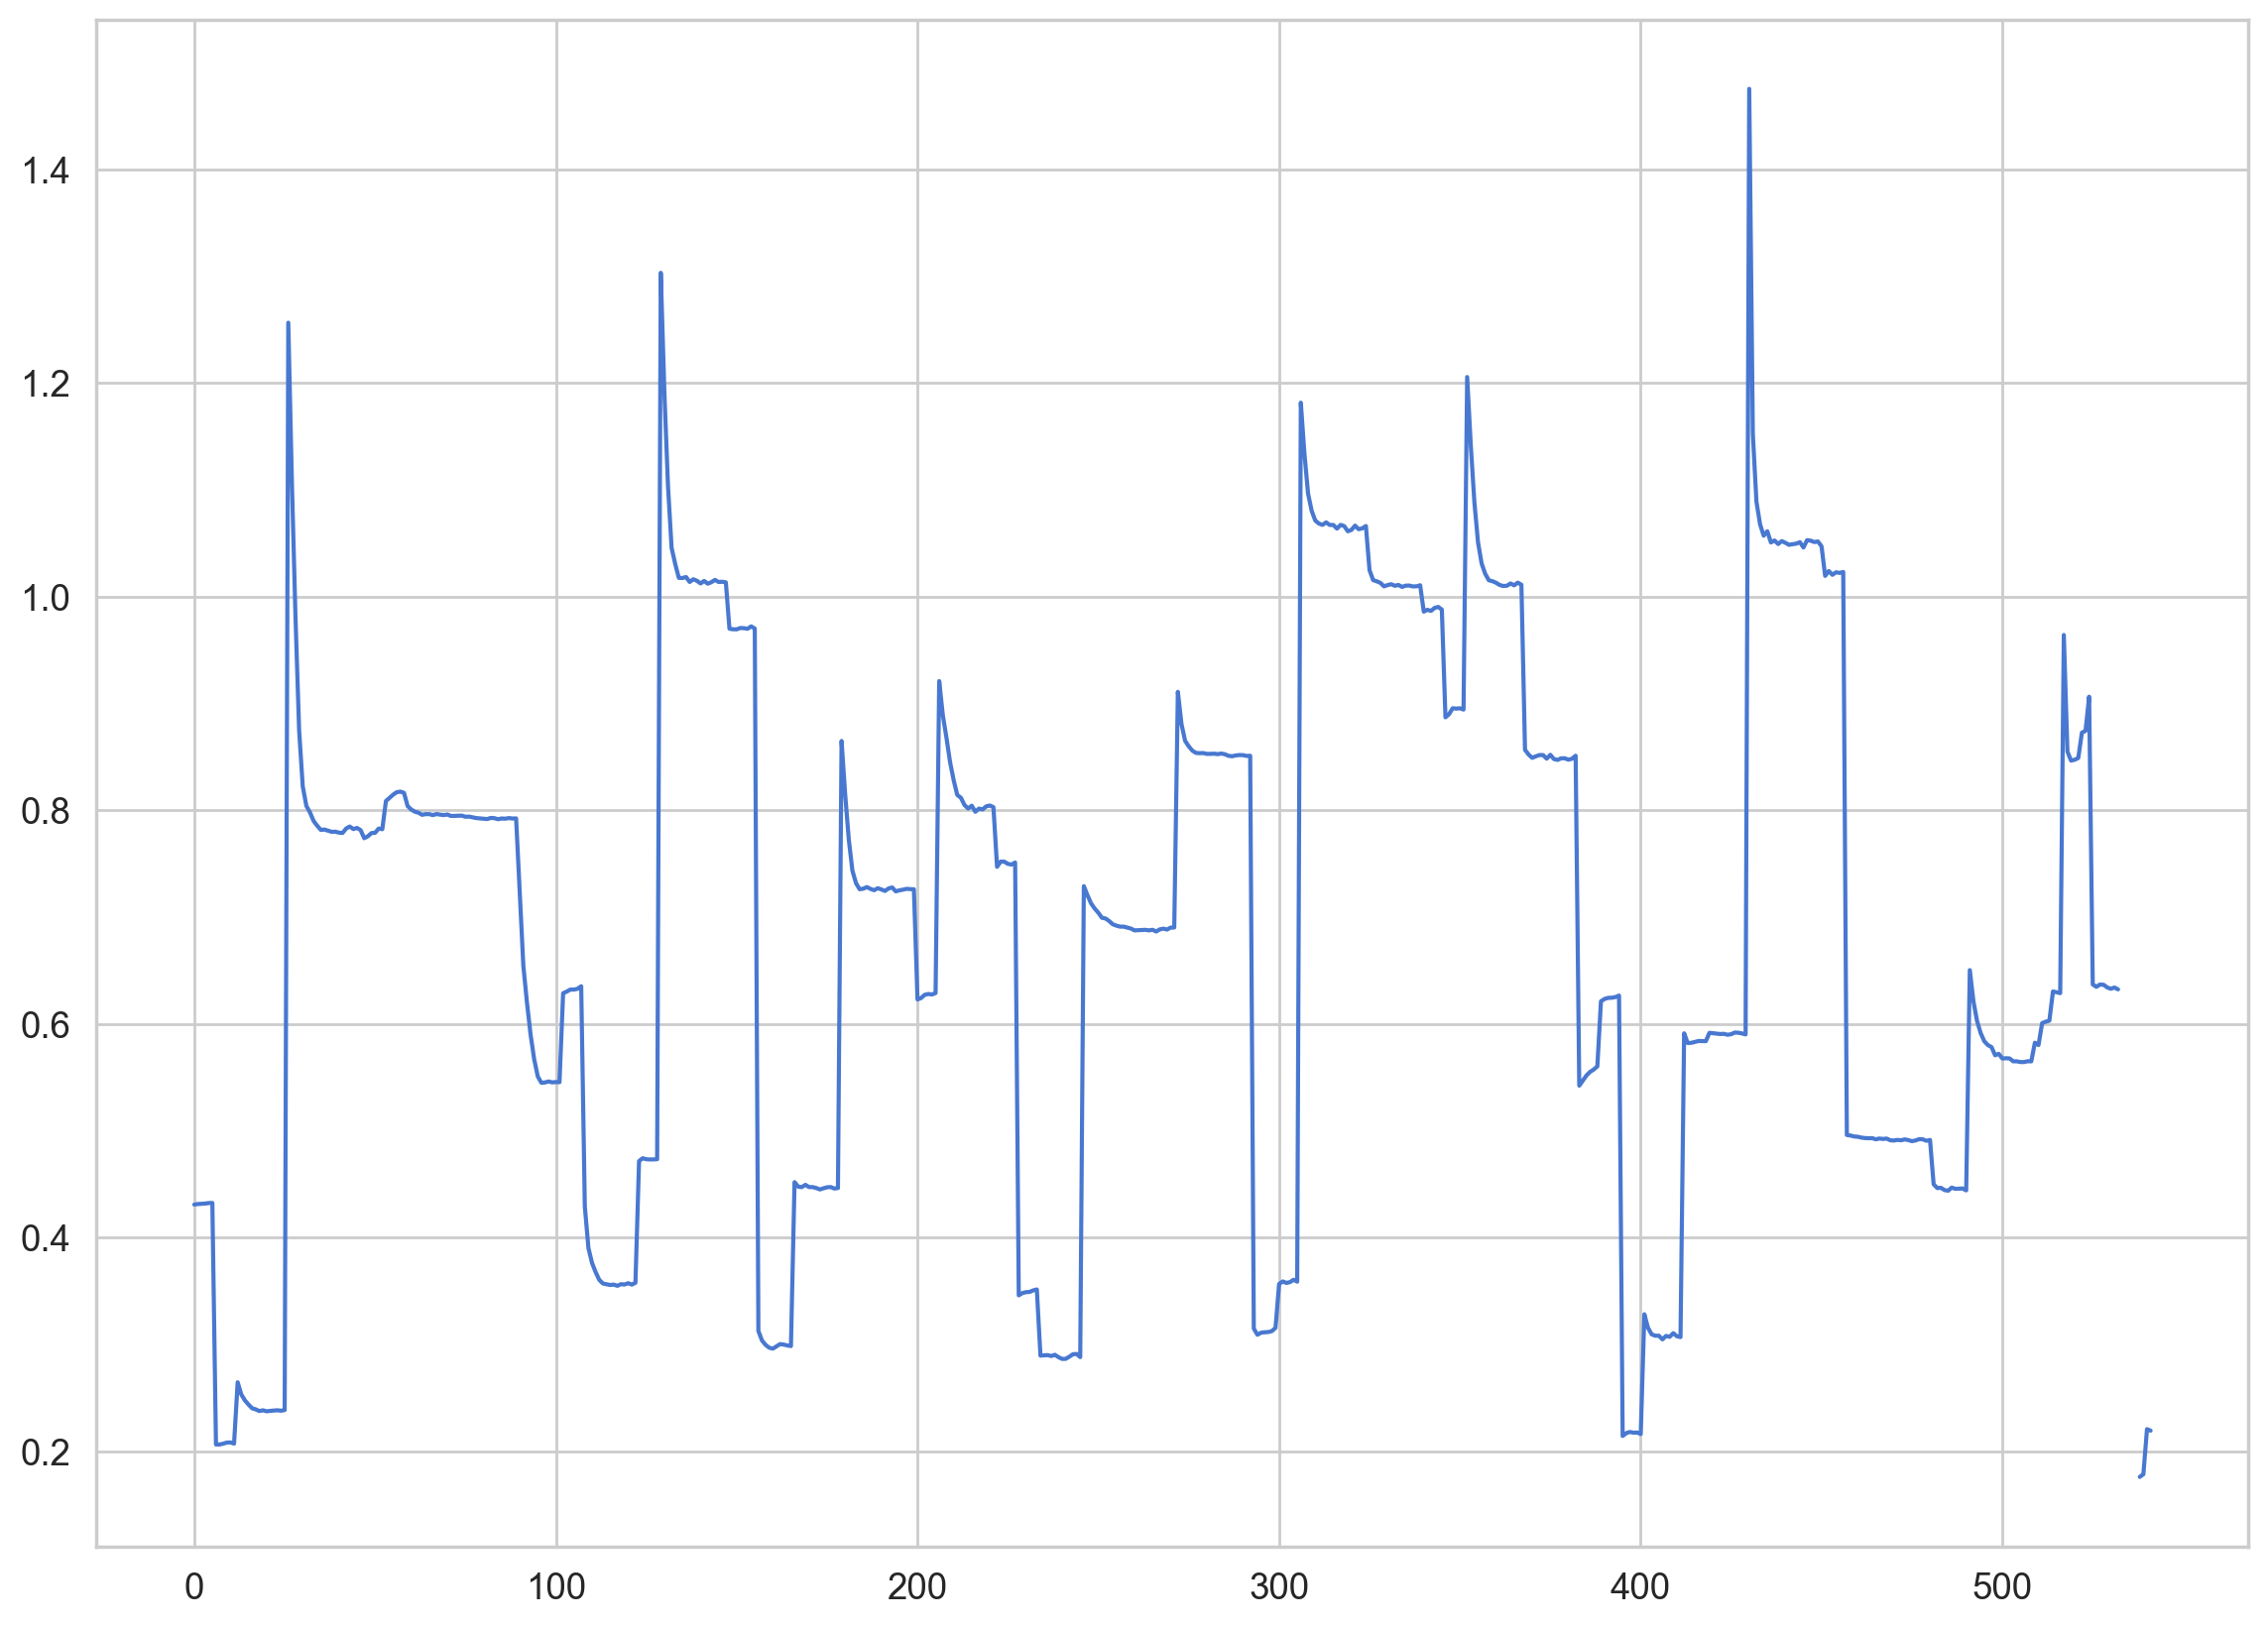

In [41]:
plt.plot(history_val_loss)

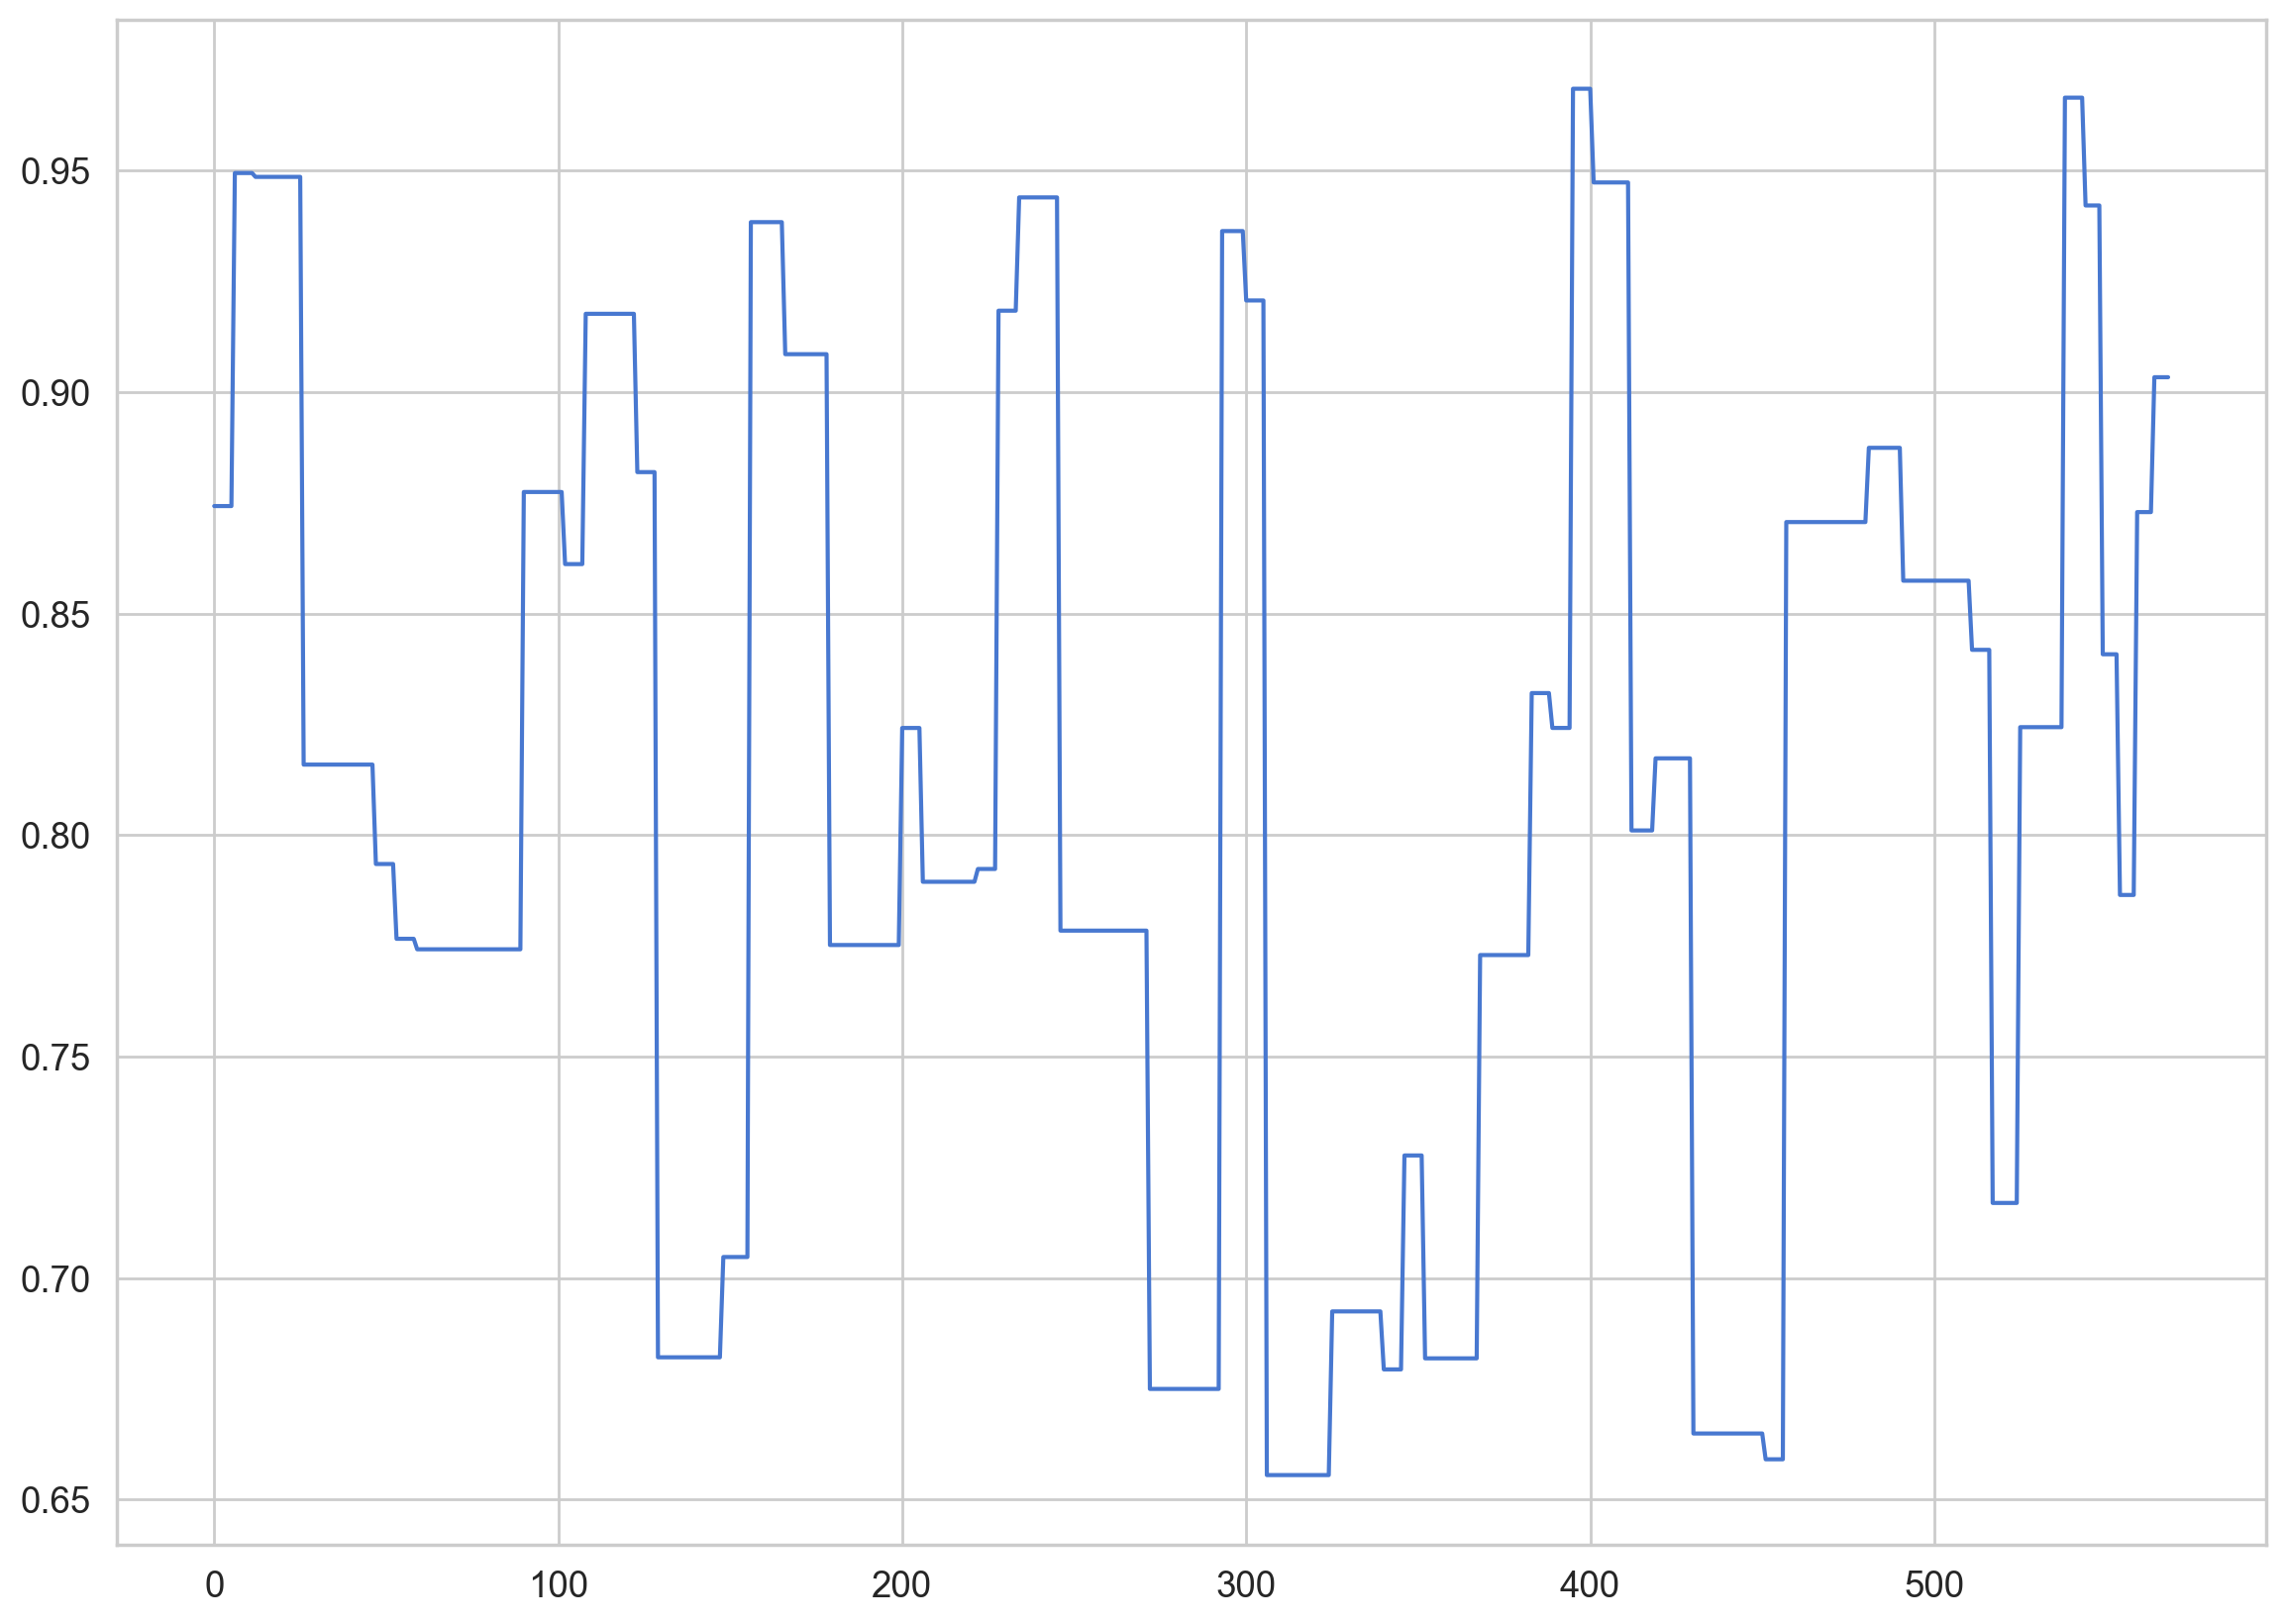

In [42]:
plt.plot(history_val_accuracy)

In [43]:
print(eval_list)

[0.872193455696106, 0.9625668525695801, 0.9396226406097412, 0.8305084705352783, 0.7858243584632874, 0.7602339386940002, 0.7622461318969727, 0.8670033812522888, 0.8811728358268738, 0.9407176375389099, 0.8671875, 0.6732673048973083, 0.7267605662345886, 0.9320388436317444, 0.9073107242584229, 0.764028787612915, 0.8216215968132019, 0.7883040904998779, 0.800000011920929, 0.9259259104728699, 0.9522546529769897, 0.7615176439285278, 0.6504369378089905, 0.9324138164520264, 0.9205955266952515, 0.6894736886024475, 0.6501687169075012, 0.6835748553276062, 0.7222808599472046, 0.6537142992019653, 0.7939109802246094, 0.8522571921348572, 0.8437899947166443, 0.9773049354553223, 0.954023003578186, 0.7691256999969482, 0.8412256240844727, 0.6600698232650757, 0.6705471277236938, 0.8781163692474365, 0.8973684310913086, 0.8632478713989258, 0.8312236070632935, 0.7467362880706787, 0.8228882551193237, 0.961399257183075, 0.9229934811592102, 0.8461538553237915, 0.8022598624229431, 0.8874251246452332, 0.88776797056

In [44]:
print(sum(eval_list)/len(eval_list))

0.8261725645439297


In [16]:
from sklearn.metrics import f1_score

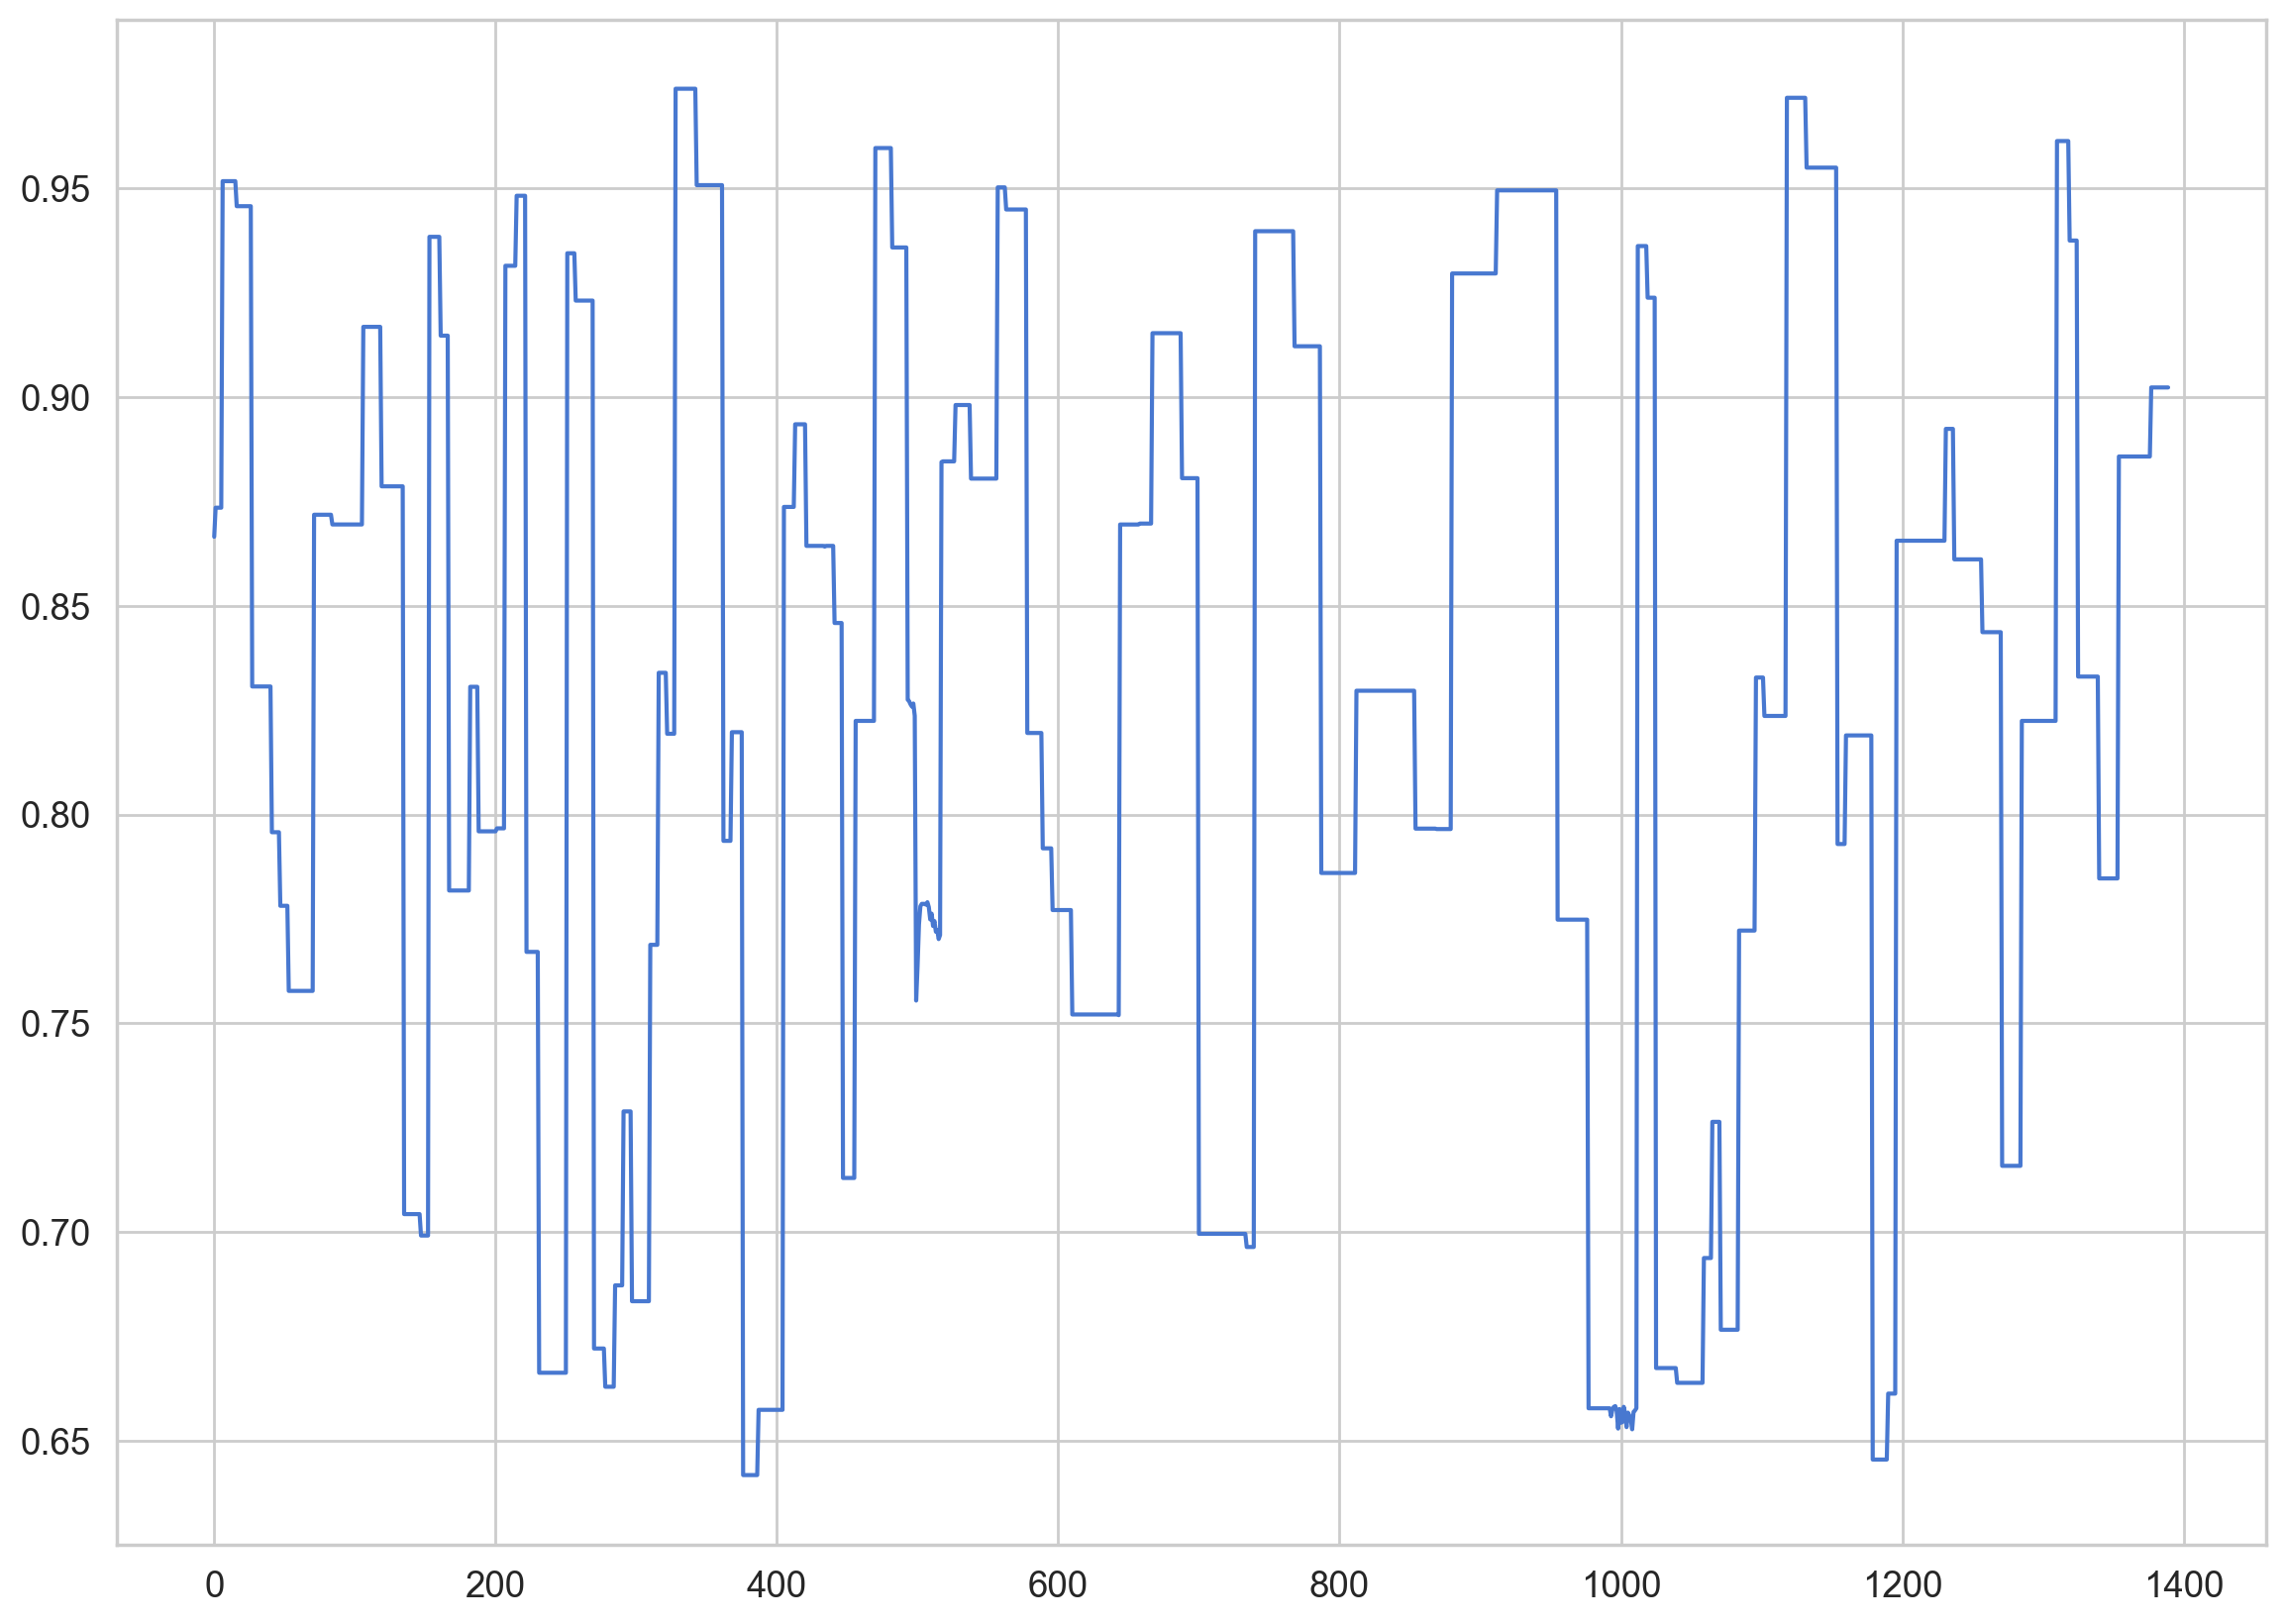

In [22]:
plt.plot(history_accuracy)